# Spike shape

author: laquitainesteeve@gmail.com

Purpose: describe ground truth action potential shapes with WaveMap clustering for biophysical evoked neuropixel demo.

Execution time: 2 mins

Special hardware: on CPU, does not require GPU.

Required resources:
- RAM: 184 GB

METHOD:
- selected sorted single-units only
- new: PEAK_SIGN is 'neg' rather than 'both' when generating templates to find the nearest site.
- new: aligned each sorted unit waveforms based on their negative peak (trough) searched in a short window of 2.5 ms surrounding the trough, to prevent waveform collisions.
- template: 
    - default average waveforms
    - not calculated with spikeinterface but inspired from Lee et al 2021 (filtering waveforms within 2 std of the mean to calculate the mean).This made the average waveform (template) more robust to outlier waveforms and more representative to the majority of observed waveforms. We did not used a absolute deviation of 0.4 which discarded to many units that seem reliable.


## Setup

Create, activate and select virtual environment kernel `demo` from (envs/demo.yml):

```bash
python -m ipykernel install --user --name demo --display-name "demo" # create kernel
```

In [254]:
%%time
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import shutil
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import extract_waveforms
import spikeinterface.core.template_tools as ttools
from spikeinterface.core.sparsity import compute_sparsity
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
from scipy.stats import kruskal
import scikit_posthocs as sp
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp # set context "fork" for macOS or "spawn"
import sklearn
import random 
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
from collections import Counter


print("spikeinterface version:", si.__version__)

# project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config, demean
from src.nodes.validation import snr
from src.nodes.validation import amplitude, power_demo, power

# setup dataset paths
RECORDING_PATH = 'dataset/00_raw/recording_npx_spont'
SORTING_KS3_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS3'

# setup recording preprocessing parameters
FREQ_MIN = 300
FREQ_MAX = 3000
REFERENCE = "global"
OPERATOR = "median"

# setup waveform parameters
WAVE_PATH = os.path.join(proj_path + "temp/waveforms/npx_spont/SortingKS3")
N_JOBS = 20                 # (default = 20) number of parallel processes for waveform extraction (20/32)
CHUNKS = 50000              # (default = 800000) use smaller chunks to use less RAM
JOB_KWARGS = dict(n_jobs=N_JOBS, chunk_size=800000, progress_bar=True)   # 20/32 cores
PEAK_SIGN = "neg"
EXT_PARAMS = {'waveforms': {'ms_before': 6.0, 'ms_after': 6.0}, 
              'templates': {'operators': ['average', 'std'], 'ms_before': 6.0, 'ms_after': 6.0},
              'random_spikes': {'seed': 0}}


# setup cortical layer parameter
lyrs = ["L5"]
prm = dict()
prm["SFREQ_NS"] = 40000  # sampling frequency
prm["SFREQ_NE"] = 20000

# plot parameters
FIG_SIZE = (1.5, 1.5)
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
CPU times: user 557 μs, sys: 138 μs, total: 695 μs
Wall time: 545 μs


## Functions

In [ ]:
def get_max_site_id(analyzer, cell_id, peak_sign="neg"):
    """get index of max site id, among the sparse subset of 
    sites used for the waveform"""

    # find nearest site to each cell
    max_chids = ttools.get_template_extremum_channel(
        analyzer, peak_sign=peak_sign
    )
    
    # get the ids of the subset of surrounding sites (sparse)
    c_ids = analyzer.sparsity.unit_id_to_channel_ids[cell_id]

    # get the nearest site (default to largest 
    # negative peak (trough))
    max_chid = max_chids[cell_id]
    return np.where(c_ids == max_chid)[0][0]


def get_waveforms_for(cell_id, analyzer, waveform_extension, peak_sign='neg'):
    
    # get the waveforms at each site (spikes, time, sites)
    waves = waveform_extension.get_waveforms_one_unit(unit_id=cell_id)

    # get the nearest site to the cell
    nearest_site_ix = get_max_site_id(analyzer, cell_id, peak_sign)
    return waves, nearest_site_ix


def align_by_neg_peak_and_crop(waves, sampling_frequency, window=100, peak_pos=50):
    """
    W: array of shape (n_waveforms, n_samples) e.g. (N, 480)
    window: number of samples in the output window (e.g. 100)
    peak_pos: index in [0, window-1] where the negative peak will be placed (e.g. 50)
    fill_value: value used when the 100-sample window would run beyond the edges
    Returns: array of shape (n_waveforms, window)
    """
    
    # find peak index in shortened waveform
    # shorten waveform to find peak without spike collision
    short_waves, wind_start, wind_end = shorten_waveform(waves, window_sec=2.5, sampling_freq=sampling_frequency)

    num_waves, _ = short_waves.shape
    left = peak_pos
    right = window - left  # number of samples to include to the right of the peak
    aligned = np.full((num_waves, window), np.nan, dtype=short_waves.dtype) # placeholder of nans

    # index of negative peak for each waveform
    trough_idx = np.argmin(short_waves, axis=1)

    # locate peak index in longer waveforms
    trough_idx = trough_idx + wind_start

    # number of timepoints in longer waves
    n_timepoints = waves.shape[1]

    for w_ix in range(num_waves):

        # desired window in original signal: [p-left, p+right)
        src_start = max(0, trough_idx[w_ix] - left)
        src_end   = min(n_timepoints, trough_idx[w_ix] + right)
        
        # where to place it in the output (shift if we clipped at edges)
        dst_start = max(0, left - trough_idx[w_ix])          # how many samples we clipped on the left
        dst_end   = dst_start + (src_end - src_start)

        # align
        aligned[w_ix, dst_start:dst_end] = waves[w_ix, src_start:src_end]

    return aligned


def shorten_waveform(waveforms:np.array, window_sec=2.5, sampling_freq=40000):

    # calculate shorter window
    sample_sec = (1/sampling_freq) * 1000
    shorter_window = int(window_sec / sample_sec)

    # get shorter window
    mid_point = int(waves.shape[1] /2)
    wind_start = int(mid_point - shorter_window/2)
    wind_end =  int(mid_point + shorter_window/2)
    shorter_window_sample = np.arange(wind_start, wind_end, 1).astype(int)
    return waveforms[:, shorter_window_sample], wind_start, wind_end


def get_single_unit_ids(Sorting):
    single_unit_ix = np.where(Sorting.get_property('KSLabel') == 'good')[0]
    return Sorting.unit_ids[single_unit_ix]


def filter_best_set_of_waves_for_the_mean(waves, n_std_of_mean=2, abs_dev=0.4):
    """see wavemap paper 
    DOI: https://doi.org/10.7554/eLife.67490

    Args:    
        waves (np.array): (n_waveforms, n_timepoints)
        
    Returns:
        selected_waves
        selected_indices
    """

    # mean and per-time-point std of the waveforms
    mean_wave = waves.mean(axis=0)
    std_wave = waves.std(axis=0)  # ddof=0 (population). Use ddof=1 if you prefer sample std.

    # Avoid divide-by-zero where a time point has zero variance
    std_safe = np.where(std_wave == 0, 1.0, std_wave)

    # Condition A: every time point is within ±2 std of the mean (pointwise)
    z = (waves - mean_wave) / std_safe
    within_2std = np.all(np.abs(z) <= n_std_of_mean, axis=1)

    # Condition B: average absolute deviation from the mean across time < 0.4
    avg_abs_dev = np.mean(np.abs(waves - mean_wave), axis=1)
    low_avg_dev = avg_abs_dev < abs_dev

    # Final selection
    mask = within_2std & low_avg_dev
    selected_indices = np.flatnonzero(mask)
    selected_waves = waves[mask]
    return selected_waves, selected_indices

## Load datasets

In [27]:
%%time 

DURATION_SEC = 600

# load recordingg and sorting extractors
Recording = si.load_extractor(RECORDING_PATH)
Recording = Recording.frame_slice(start_frame=0, end_frame=Recording.sampling_frequency * DURATION_SEC)
print(Recording)

Sorting = si.load_extractor(SORTING_KS3_PATH)
Sorting = Sorting.frame_slice(start_frame=0, end_frame=Sorting.sampling_frequency * DURATION_SEC)
print(Sorting)

FrameSliceRecording: 384 channels - 40.0kHz - 1 segments - 24,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 34.33 GiB
FrameSliceSorting: 1684 units - 1 segments - 40.0kHz
CPU times: user 7 ms, sys: 6.91 ms, total: 13.9 ms
Wall time: 13.7 ms


## Compute waveforms

- Execution time: 31 mins

In [256]:
# %%time 

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
Recording = spre.bandpass_filter(Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
Recording = spre.common_reference(Recording, reference=REFERENCE, operator=OPERATOR)
Recording = spre.whiten(Recording, dtype='float32') # requires float

# # extract waveforms
# WaveformExtractor = extract_waveforms(Recording, Sorting, WAVE_PATH, sparse=True, 
#     ms_before=MS_BEFORE, ms_after=MS_AFTER, max_spikes_per_unit=500, unit_batch_size=None, 
#     overwrite=None,  seed=0, **JOB_KWARGS)

# extract waveforms for the 30 sites  nearest to each sorted cell
# check parameters with analyzer.get_extension(extension_name="templates").params
analyzer = si.create_sorting_analyzer(sorting=Sorting, recording=Recording, format="memory")
analyzer.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
analyzer.sparsity = compute_sparsity(templates_or_sorting_analyzer=analyzer, method="best_channels", num_channels=30)
wave_ext = analyzer.get_extension('waveforms')

compute_waveforms: 100%|##########| 600/600 [15:31<00:00,  1.55s/it]


nb of single units: 335
nb of filtered waves: 264


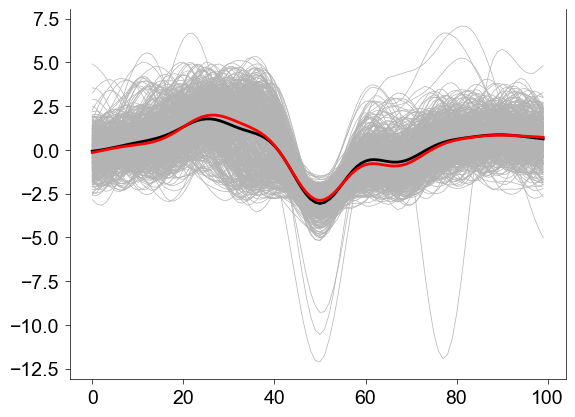

In [ ]:
# setup parameters
# these make the average waveform (template) more robust to outlier waveforms
# and more representative to the majority of observed waveforms
ABS_DEV = np.inf     # (default=0.4) as in lee et al 2021's wavemap paper
N_STD_OF_MEAN = 2    # (default=2) as in lee et al 2021's wavemap paper



# 1. put aside units with positive waveforms

# for other units 
# - 2. align in time via their trough (negative peak) for each nearest site
# - 3. average waveforms for each nearest site
# - 4. record the nearest site (largest negative peak)
# - 5. normalized between -1 and 1

# get the nearest sites
max_chids = ttools.get_template_extremum_channel(analyzer, peak_sign=PEAK_SIGN)

# get single units
single_units = get_single_unit_ids(Sorting)
print('nb of single units:', len(single_units))

# for each sorted cell
# note: 18 is positive spike
# note: 21 triphasic
ix = 29

cell_id = single_units[ix]

# get waveforms per site and nearest site index
waves, nearest_site_ix = get_waveforms_for(cell_id, analyzer, wave_ext, peak_sign='neg')

# 2. align waveforms for the nearest site
aligned_100_ms = align_by_neg_peak_and_crop(waves[:,:,nearest_site_ix], Recording.sampling_frequency, window=100, peak_pos=50)

# 3. average waveforms for the nearest site
# - select best waveforms on the nearest site to calculate a reliable average waveform
filtered_waves, filtered_waves_ix = filter_best_set_of_waves_for_the_mean(aligned_100_ms, n_std_of_mean=N_STD_OF_MEAN, abs_dev=ABS_DEV)
print('nb of filtered waves:', len(filtered_waves))


# plt.plot(aligned_100_ms.T, color=(0.7,0.7,0.7)); # each wave
# plt.plot(np.nanmean(aligned_100_ms ,axis=0),'k', linewidth=2); # template
# plt.plot(np.nanmean(filtered_waves ,axis=0),'r', linewidth=2); # template


### Largest spike templates on six sites

* The six largest templates are typically on six nearby sites.
* We get them and order them from largest to smallest for each unit

In [9]:
%%time

# CUSTOM FUNCTION FOR PARALLEL COMPUTING
# Get each unit's six largest spike templates on six sites
# and re-order in descending order

nsamples = WaveformExtractor.nsamples # number of waveform samples
sites_ix = np.arange(0, RecordingE.get_num_channels(),1) # site indices

# report
print("# of samples of a waveform:", nsamples)
print("sites:", sites_ix)

# unit-test
assert (MS_BEFORE + MS_AFTER) * RecordingE.get_sampling_frequency()/ 1000 == nsamples, "nsamples should match"

def get_unit_largest_templates_parallelized(dummy, cell_id: int):
    """Get each unit's six largest spike templates on six sites
    and re-order in descending order.
    
    Align unit spikes by first extracting -6:+6 ms before 
    and after the spike timestamp then centering unit templates on 
    their trough (maximal negative peak), teducing the template 
    period to -3:+3 ms before applying wavemap

    """

    N_SPIKES = 6 # six largest spikes on six sites
    MSAMP_BASELINE = 20 # window to evaluate background noise ref. for normalization
    wfs = WaveformExtractor.get_waveforms(cell_id) # waveforms (n_spikes, n_samples, n_sites)
    nsamples = wfs.shape[1] # # of waveform samples
    N_SITES = wfs.shape[2] # number of sites
    SFREQ = WaveformExtractor.sampling_frequency # sampling frequency

    # shorten period to -3 and +3ms to avoid
    # collisions from other spikes
    MS_AROUND_DENOISE = 3
    nsamples_denoise = int(MS_AROUND_DENOISE * SFREQ / 1000) # e.g., 60 timepoints
    timestamp_sample = int(nsamples/2)

    # shorted-period waveforms (n_spikes, nsamples/2, n_sites)
    wfs_short = wfs[:,timestamp_sample - nsamples_denoise: timestamp_sample + nsamples_denoise, :]

    # get this unit's templates per site
    site_templates = []
    peak1_amps = []
    trough_amps = []
    peak2_amps = []

    # get template features per sites
    #for _, site in enumerate(SITES_IN_CTX_IX):
    for site in range(N_SITES):

        # calculate template ((nsamples,))
        template_short = np.median(wfs_short[:, :, site].T, axis=1)
        template = np.median(wfs[:, :, site].T, axis=1)

        # subtract baseline: e.g.,voltage of 20 first timepoints 
        # ((nsamples,))
        template_short -= np.median(template_short[:MSAMP_BASELINE])
        template -= np.median(template[:MSAMP_BASELINE])

        # find peak 1 (trough), and peak 2 (amplidude) voltages
        # - if trough is at time 0, there is too much noise
        # thus set the site data to 0 -> will not be picked
        # up for max trough, or peak
        ix_trough = np.argmin(template_short)
        if ix_trough == 0:
            peak1_amps.append(0)
            trough_amps.append(0)
            peak2_amps.append(0)
        else:
            peak1_amps.append(template_short[np.argmax(template_short[:ix_trough])])
            trough_amps.append(template_short[ix_trough])
            peak2_amps.append(template_short[np.argmax(template_short[ix_trough:])])

        # recording full template for each site 
        # list of (nsamples,) templates with length N_SITES
        site_templates.append(template)

    # (nsamples, n_sites) e.g., 240 x 30 (for sparse waveformextractor)
    site_templates = np.array(site_templates).T

    # get amplitudes from peak1 (row 1), trough (row 2)or peak2 (row3),
    # depending on which is largest across sites
    peaks_and_trough = np.vstack(
        [np.array(peak1_amps), np.array(trough_amps), np.array(peak2_amps)]
    )
    peak1_trough_or_peak2 = np.argmax(np.nanmax(np.abs(peaks_and_trough), axis=1))

    # if peak, reorder sites based on peak, else on trough
    descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])[::-1]

    # case trough
    if peak1_trough_or_peak2 == 1:
        descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])

    # order associated sites (n_sites,)
    ordered_sites = np.arange(0, N_SITES, 1)[descend_sort_ix]

    # make a vector
    # (nsamples, n_spikes) e.g., (240, 6 largest spike descending)
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]]
    unit_i_spike =  unit_i_spike.T.flatten() # (240 * 6,)
    assert unit_i_spike.shape[0]==nsamples*N_SPIKES, "unit_i_spike should be nsamples*n_spikes"
    return {"templates": unit_i_spike, "sites": ordered_sites}

# of samples of a waveform: 240
sites: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
CPU times: user 400 μs, sys: 152 μs, total: 552 μs
Wall time: 486 μs


In [47]:
%%time 

# parameters
MIN_N_SPIKES = 30 # minimum number of spikes for a unit to be considered

# get all unit ids
single_units = WaveformExtractor.unit_ids

# select the most active units (ensuring they have sufficient spikes to 
# produce a reasonable average template)
n_spikes = [len(SortingE.get_unit_spike_train(unit)) for ui, unit in enumerate(single_units)] # num spikes
sorted_ix = np.argsort(n_spikes)[::-1] # sort by num spikes ascending
n_spikes = np.array(n_spikes)[sorted_ix]
sorted_single_units = single_units[sorted_ix]
selected_units = sorted_single_units[n_spikes > MIN_N_SPIKES] # select most active
print("# of selected units:", len(selected_units))

# compute unit's six largest templates (parallelized over units)
with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, len(single_units), 1),  # dummy, not used
        selected_units,
    )

# get templates
site_templates = list(site_templates)

# format data for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
sites = []
for ix in range(len(selected_units)):
    site_templates_all.append(site_templates[ix]["templates"].tolist())
    sites.append(site_templates[ix]["sites"].tolist())
templates_for_wavemap = np.array(site_templates_all)

# keep non-nan (existing) spike templates
#has_spike_unit_ix = np.where(np.isnan(templates_for_wavemap).sum(axis=1)==0)[0]
#templates_for_wavemap = templates_for_wavemap[has_spike_unit_ix, :]
#single_units_has_spike = selected_units[has_spike_unit_ix]

# of selected units: 548
CPU times: user 486 ms, sys: 1.54 s, total: 2.03 s
Wall time: 3 s


### Align spike templates

* templates are aligned based on the location of their trough for each unit.

In [48]:
%%time
# parameters
ALIGNED_AROUND = 60 # 60 timepoints for 2 ms before and after the spike timestamp

# number of sites
n_sites_for_umap = int(templates_for_wavemap.shape[1] / nsamples)
print("# sites to use for UMAP:", n_sites_for_umap)

# isolate each unit's largest template (because 
# we order all spike templates for each unit (row) 
# in descending order (it is the first template, i.e., 
# first nsamples timepoints).
largest_templates = templates_for_wavemap[:, :nsamples]
print("largest template shape:", largest_templates.shape)

# initialize variables
aligned_temps = [] # aligned templates
units = [] # units kept
ix_troughs = [] # index of spike trough

# loop over units
for ix in range(len(selected_units)):

    # find spike trough
    ix_trough = np.argmin(largest_templates[ix, :])

    # align the templates for each site
    # to the location of the first positive peak of
    # the largest template
    templates_unit_i = []

    # loop over number of sites to use 
    # for clustering (e.g., 6 sites)
    for jx in range(n_sites_for_umap):
        
        # Keep the units for which the trough is such that
        # the period before the spike timestamp is
        # positive (no loss of waveform timepoints before)
        # and the period after is lower than the total number of
        # timepoints. This is to only keep the waveforms that do 
        # not lose timepoint samples after alignment.
        if jx * nsamples + ix_trough - ALIGNED_AROUND > 0:
            if jx * nsamples + ix_trough + ALIGNED_AROUND < templates_for_wavemap.shape[1]:

                # align templates to peak
                try:
                    aligned_tp = templates_for_wavemap[
                            ix,
                            jx * nsamples
                            + ix_trough
                            - ALIGNED_AROUND : jx * nsamples
                            + ix_trough
                            + ALIGNED_AROUND,
                        ]
                    templates_unit_i.append(aligned_tp)
                    
                    # check that the aligned template is of the right size
                    assert aligned_tp.shape[0] == 2*ALIGNED_AROUND
                except:
                    print("reduce the length of the preceding and following periods")
                
    try:
        # re-concatenate into a single row vector
        templates_unit_i2 = np.array(templates_unit_i).flatten()
        
        # we keep units for which no spike waveform samples were lost
        # during the alignment
        if templates_unit_i2.shape[0]== 2*ALIGNED_AROUND * n_sites_for_umap:
            aligned_temps.append(templates_unit_i2)
        
            # record the index of the units we kept
            units.append(ix)
    except:
        pass
        
# concatenate all the templates that could be aligned
# without loss of waveform sample
aligned_temps = np.array(aligned_temps)
units_kept = selected_units[np.unique(units)]

# sites to use for UMAP: 6
largest template shape: (548, 240)
CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 14.3 ms


## Plot

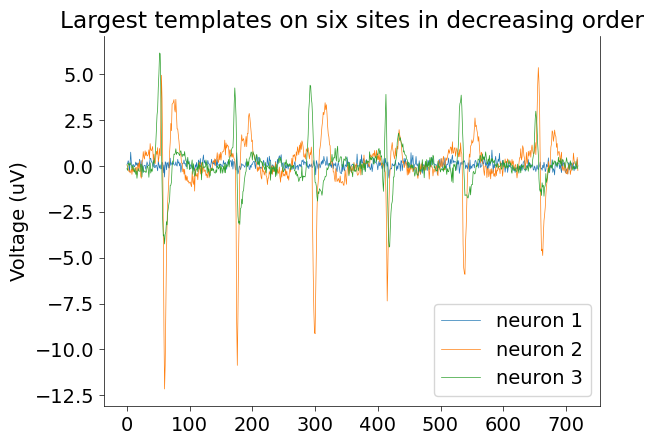

In [49]:
# plot three neurons' largest templates (average spikes over site) for six sites.
plt.plot(aligned_temps[:3,: ].T);
plt.legend(["neuron 1", "neuron 2", "neuron 3"]);
plt.title("Largest templates on six sites in decreasing order");
plt.ylabel("Voltage (uV)");

### Wavemap-cluster the aligned spatiotemporal waveforms

* the temporal waveforms are spread on the six sites.

In [52]:
%%time 

# Full waveform length in timepoints (should be 6 ms)
SPIKE_PERIOD = int(
    aligned_temps.shape[1] / n_sites_for_umap
)  
RAND_STATE = 42

# normalize waveform amplitudes between 0 and 1.
normWFs = sklearn.preprocessing.normalize(aligned_temps, norm="max")

# reduce waveform dimensionality with UMAP
# umap reduces to two dimensions by default
np.random.seed(RAND_STATE)
os.environ["PYTHONHASHSEED"] = str(RAND_STATE)
random.seed(RAND_STATE)
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

# clustering with Louvain
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = community_louvain.best_partition(G)
clustering_solution = list(clustering.values())

# create 2D embedding
embedding = reducer.fit_transform(normWFs)

# get cluster profiles
umap_df = pd.DataFrame(embedding, columns=("x", "y"))
umap_df["waveform"] = list(normWFs)
umap_df["cluster_id"] = clustering_solution

# get cluster profiles
profiles = np.unique(umap_df["cluster_id"])

CPU times: user 1min 13s, sys: 12 s, total: 1min 25s
Wall time: 7.16 s


## Plot embeddings

profile (count): 7
profiles: [0 1 2 3 4 5 6]
CPU times: user 33 ms, sys: 0 ns, total: 33 ms
Wall time: 32.2 ms


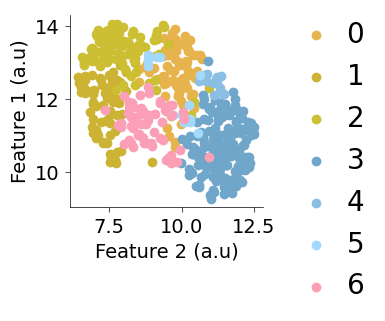

In [55]:
%%time 

# set color of cluster profiles
colors = np.array(
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        # [1, 0, 0],  # red
        # [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        # [254 / 255, 235 / 255, 226 / 255],  # purple variation
        # [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

# plot embedding
f, ax = plt.subplots(1, figsize=(2.5,2.5))
for ix, profile_i in enumerate(profiles):
    ax.scatter(
        umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
        umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
        marker="o",
        color=colors[ix],
        label=profile_i,
    )

# legend
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Feature 1 (a.u)")
ax.set_xlabel("Feature 2 (a.u)")
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **legend_cfg)

# report cluster profile identifiers
print("profile (count):", len(np.unique(umap_df["cluster_id"])))
print("profiles:", profiles)

## Plot spike shape clusters

as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the second largest peak to peak amplitude

2025-04-07 14:38:54,816 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,915 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,940 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,976 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38

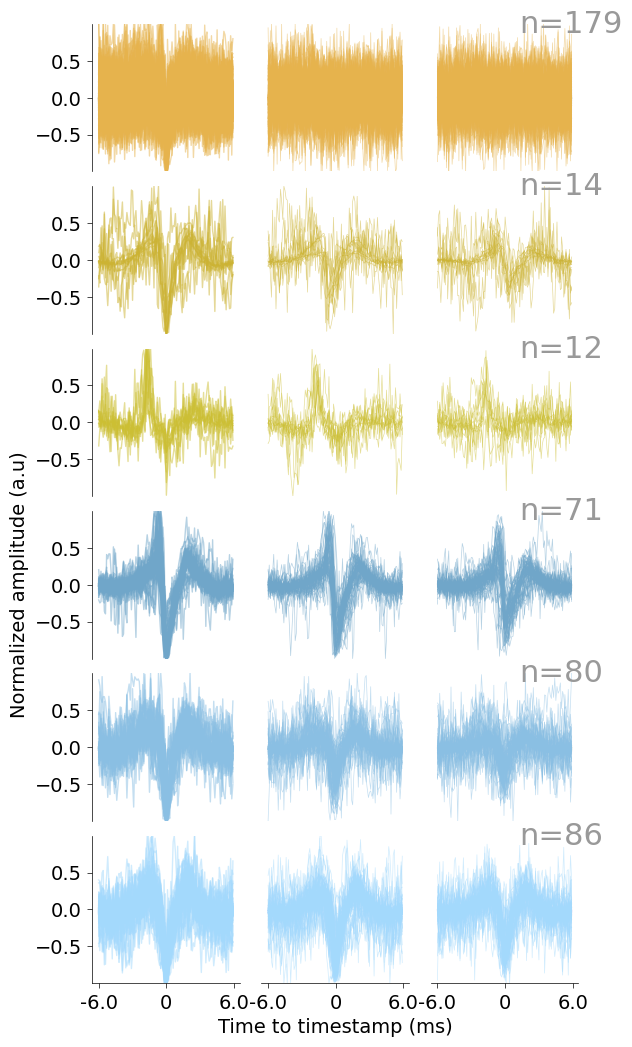

In [63]:
%%time 

counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [3, 5, 4, 1, 0, 2]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 7 * 1.5))

YLIM = [-1, 1]

# loop over waveform clusters
for ix, profile_i in enumerate(profiles):

    # site 1
    axes[ix, 0].plot(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=1,
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].set_yticks([-0.5, 0, 0.5])
    axes[ix, 0].set_ylim(YLIM)
    if ix == 3:
        axes[ix, 0].set_ylabel("Normalized amplitude (a.u)")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    axes[ix, 1].plot(
        normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticks([-0.5, 0, 0.5])
    axes[ix, 1].set_ylim(YLIM)
    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    axes[ix, 2].plot(
        normWFs[
            umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
        ].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 2].set_box_aspect(1)  # square axis
    axes[ix, 2].set_yticks([-0.5, 0, 0.5])
    axes[ix, 2].set_ylim(YLIM)
    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.6, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )

fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.45, hspace=0.1)